In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import matplotlib.pyplot as plt


In [2]:
import os

current_directory = os.getcwd()
print("Current directory:", current_directory)




Current directory: c:\Users\shash\Downloads\CHILLI-DISEASE-DETECTION


In [3]:
# Define paths
data_dir = "Dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define transforms for data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


print(data_dir)


Dataset


In [6]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the ResNet-50 model
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Epoch [1/10], Train Loss: 0.9088, Test Loss: 0.4196, Train Acc: 66.82%, Test Acc: 84.07%
Epoch [2/10], Train Loss: 0.4060, Test Loss: 0.3096, Train Acc: 86.08%, Test Acc: 91.15%
Epoch [3/10], Train Loss: 0.2788, Test Loss: 0.3836, Train Acc: 90.37%, Test Acc: 87.61%
Epoch [4/10], Train Loss: 0.2419, Test Loss: 0.4466, Train Acc: 91.68%, Test Acc: 89.38%
Epoch [5/10], Train Loss: 0.2306, Test Loss: 0.4660, Train Acc: 91.90%, Test Acc: 86.73%
Epoch [6/10], Train Loss: 0.2006, Test Loss: 0.4441, Train Acc: 92.66%, Test Acc: 89.38%
Epoch [7/10], Train Loss: 0.1818, Test Loss: 0.5132, Train Acc: 93.68%, Test Acc: 89.38%
Epoch [8/10], Train Loss: 0.1457, Test Loss: 0.4027, Train Acc: 95.29%, Test Acc: 91.15%
Epoch [9/10], Train Loss: 0.1383, Test Loss: 0.5317, Train Acc: 95.04%, Test Acc: 87.61%
Epoch [10/10], Train Loss: 0.1078, Test Loss: 0.4867, Train Acc: 96.44%, Test Acc: 89.38%


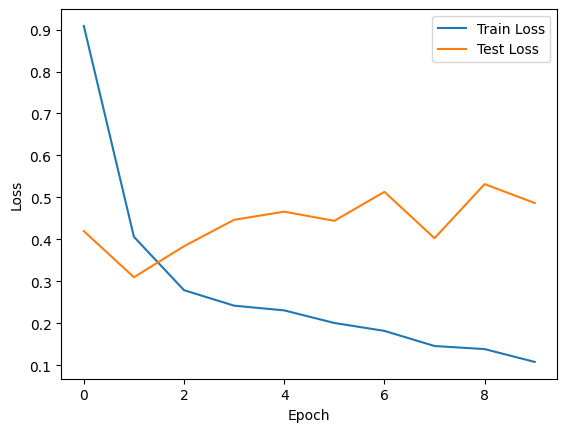

In [7]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    correct_train = 0
    correct_test = 0

    # Training
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    # Testing
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, '
          f'Train Acc: {100.0 * correct_train / len(train_loader.dataset):.2f}%, '
          f'Test Acc: {100.0 * correct_test / len(test_loader.dataset):.2f}%')

# Plot the training and testing losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'best.pth')

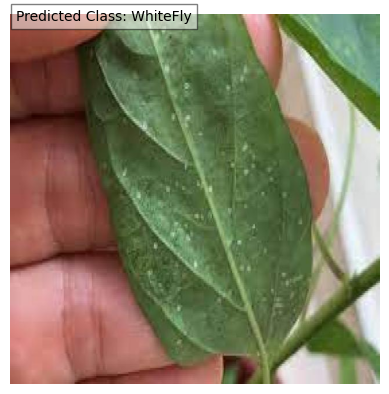

In [11]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Define transforms for test image
inference_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the trained model
model = models.resnet152()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # Assuming 6 output classes
model.load_state_dict(torch.load('best.pth'))
model.eval()

# Function to predict class for an image
def predict_image_class(image_path):
    image = Image.open(image_path)
    image_tensor = inference_transforms(image).unsqueeze(0)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        class_index = predicted.item()
        return class_index

# Inference on a test image
test_image_path = 'Dataset/test/whitefly/download-27-_jpg.rf.44290bdbdfcecaacc51e88acfa9e630f.jpg'
predicted_class_index = predict_image_class(test_image_path)

# Define class labels
class_labels = ['Healthy', 'Leaf Curl', 'Leaf Spot', 'Powdery Mildew', 'WhiteFly', 'Yellowish']

# Get predicted class label
predicted_class = class_labels[predicted_class_index]

# Display the image with the predicted class label on top
image = Image.open(test_image_path)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted Class: {predicted_class}', bbox=dict(facecolor='white', alpha=0.5))
plt.show()
